In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loss landscape plot

plot_surface.py

In [ ]:
!python plot_surface.py --model WideResNet --x=-1:1:5 --y=-1:1:5 --model_file ../to_plot/model_cifar_halfSAM_rho0.5.pt --dir_type weights --xnorm filter --xignore biasbn --ynorm filter --yignore biasbn --plot --percentage=0.3 --loss_name smooth_crossentropy

------------------------------------------------------------------
plot_2d_contour
------------------------------------------------------------------
loading surface file: ../to_plot/model_cifar_halfSAM_rho0.5.pt_weights_xignore=biasbn_xnorm=filter_yignore=biasbn_ynorm=filter.h5_[-1.0,1.0,5]x[-1.0,1.0,5].h5
len(xcoordinates): 5   len(ycoordinates): 5
max(train_loss) = 7.755047 	 min(train_loss) = 0.875943
[[2.40649363 2.45352721 2.37080363 2.33494368 3.27218929]
 [2.11266517 1.72538848 1.35355867 1.86808758 2.42179902]
 [1.96148256 1.27078478 0.87594321 1.30209623 2.05305649]
 [2.82968777 1.60050254 1.09351784 1.46998333 1.97798065]
 [7.75504659 2.75616385 1.72724978 1.85543291 2.30363232]]
model_cifar_halfSAM_rho0.5_[-1.0,1.0,5]x[-1.0,1.0,5]


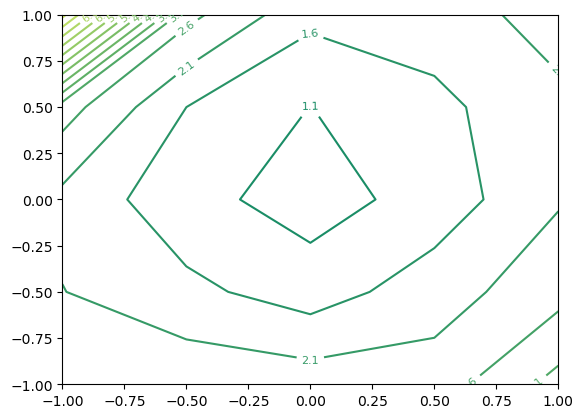

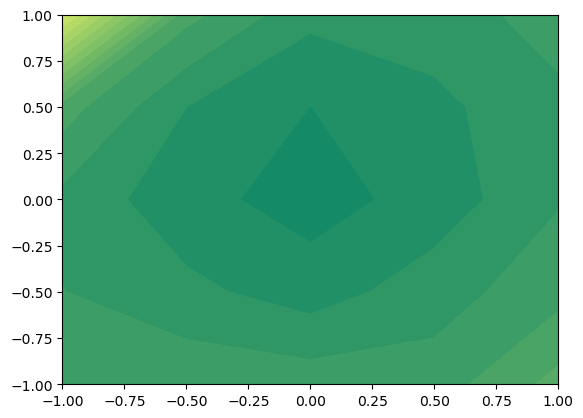

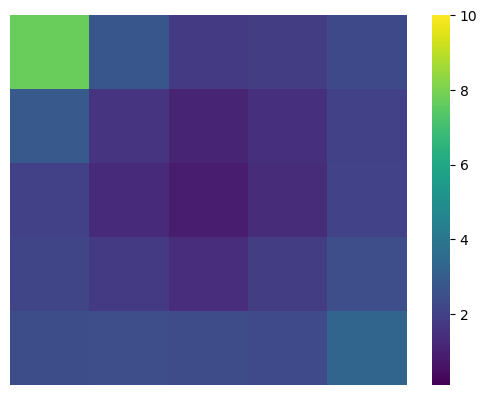

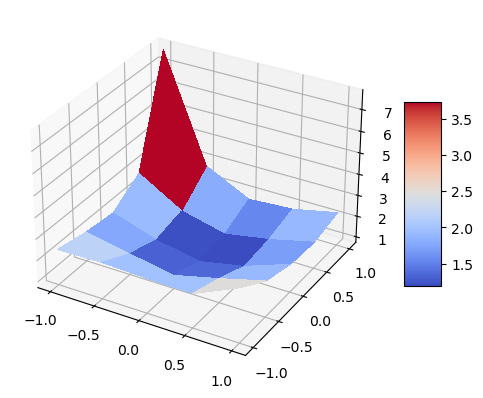

In [47]:
from plot_2D import plot_2d_contour
# surf_file = '../to_plot/model_cifar_SGD.pt_weights_xignore=biasbn_xnorm=filter_yignore=biasbn_ynorm=filter.h5_[-1.0,1.0,5]x[-1.0,1.0,5].h5'
surf_file = '../to_plot/model_cifar_halfSAM_rho0.5.pt_weights_xignore=biasbn_xnorm=filter_yignore=biasbn_ynorm=filter.h5_[-1.0,1.0,5]x[-1.0,1.0,5].h5'
plot_2d_contour(surf_file, 'train_loss', 0.1, 10, 0.5, False)

## Eigenvalues of hessian

plot_hessian_eigen.py

In [1]:
# !python plot_hessian_eigen.py --model WideResNet --x=-1:1:3 --y=-1:1:3 --model_file model_acc_state.pt --dir_type weights --xnorm filter --xignore biasbn --ynorm filter --yignore biasbn --plot --percentage=0.05 --loss_name smooth_crossentropy

Using pyhessian

In [48]:
import numpy as np
import torch 
from torchvision import datasets, transforms
# from pytorchcv.model_provider import get_model as ptcv_get_model # model

import matplotlib.pyplot as plt

In [49]:
from my_pyhessian import hessian, utils# Hessian computation
from my_pyhessian.density_plot import get_esd_plot

In [56]:
import sys; sys.path.append("..")
from models.smooth_cross_entropy import mean_smooth_crossentropy
from models.wide_res_net import WideResNet
from cifar.cifar import Cifar

In [57]:
# stored = torch.load('../to_plot/model_cifar_SGD.pt', map_location=lambda storage, loc: storage)
stored = torch.load('../to_plot/model_cifar_halfSAM_rho0.5.pt', map_location=lambda storage, loc: storage)
model = WideResNet(8, 2, 0.0, in_channels=3, labels=10)

if 'state_dict' in stored.keys():
    model.load_state_dict(stored['state_dict'])
else:
    model.load_state_dict(stored)
model.eval()

# create loss function
# criterion = torch.nn.CrossEntropyLoss()
criterion = mean_smooth_crossentropy

# get dataset 
dataset = Cifar(0.3, 128, 2)
trainloader, testloader = dataset.train, dataset.test


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [84]:
num_batches = 10

inputs = None
targets = None
for ind, (data, tar) in enumerate(trainloader):
    if inputs is None:
        inputs = data
        targets = tar
    elif inputs is not None and ind < num_batches:
        inputs = torch.cat((inputs, data), 0)
        targets = torch.cat((targets, tar))
    else:
        break

print(inputs.size(), targets.size())

# For multiple batches
# dataloader = trainloader

# we use cuda to make the computation fast
# model = model.cuda()
# inputs, targets = inputs.cuda(), targets.cuda()

torch.Size([1280, 3, 32, 32]) torch.Size([1280])


In [85]:
# create the hessian computation module
hessian_comp = hessian(model, criterion, data=(inputs, targets), cuda=False) # Single batch
# hessian_comp = hessian(model, criterion, dataloader=dataloader, cuda=False) # Whole training set

In [ ]:
density_eigen, density_weight = hessian_comp.density(iter=100, n_v=1)

In [ ]:
density_eigen

In [87]:
get_esd_plot(density_eigen, density_weight,'eig_cifar_halfSAM_rho05.png')

C:\Users\franc\Desktop\Francesco\EPFL_Courses\Optimization for ML\sharpness-aware_minimization\loss_landscape\my_pyhessian\density_plot.py:64: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])
C:\Users\franc\anaconda3\envs\ml\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\franc\anaconda3\envs\ml\lib\site-packages\matplotlib\transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000214C0AACE50>
Traceback (most recent call last):
  File "C:\Users\franc\anaconda3\envs\ml\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "C:\Users\franc\anaconda3\envs\ml\lib\site-packages\tor

In [ ]:
# Now let's compute the top eigenvalue.
top_eigenvalues, top_eigenvector = hessian_comp.eigenvalues(maxIter=10, top_n = 1)
print("The top Hessian eigenvalue of this model is %.4f"%top_eigenvalues[-1])